# [Computational Social Science] Project 4: Unsupervised Learning

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

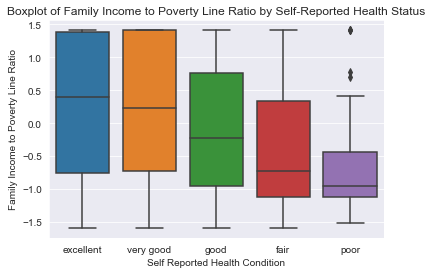

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

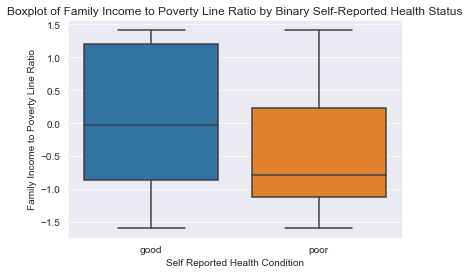

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

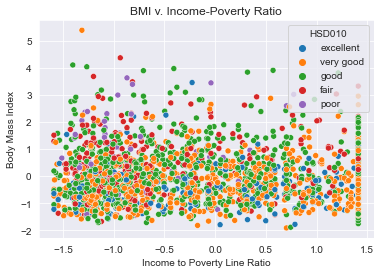

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled_X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [7]:
nhanes_scaled_X.shape

(2064, 241)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

James et. al. (2013: 383) state that "In general, a n x p data matrix has min(n x 1, p) distinct principal
components." but we are obviously not interested in all of them. In this case, we can plot all of them to see the variation explained by each in the plot below. We could then, in theory, set the number of principal components to 240 because the first of the 241 columns in the matrix is the index. However, we choose to include only 30 for a start to get a better visual of the variance explained by the first 30 as an arbitrary number. We expect to not include more than 30 in any case, as the variation explained declines with each principal component.

In [8]:
pca = PCA(n_components=30)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_X)

In [9]:
nhanes_scaled_X.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


### Barplot of Components

Now, we plot a barplot of the variation explained by each component.

In [10]:
pca_df = pd.DataFrame(data = principalComponents_nhanes)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,9.527808,-0.816221,-1.868081,-2.108121,-3.930095,-0.179049,-3.841871,-2.946065,1.531180,0.683736,...,-0.223855,-0.511702,0.363677,0.440481,-1.314841,-0.579369,-0.133072,-0.282668,-0.614597,-0.076011
1,-5.838345,-3.692587,3.807545,-1.031807,0.401016,1.596274,2.724678,-0.739950,0.300928,-2.442355,...,-0.183038,-0.505949,1.341194,4.910683,-1.217748,-0.734808,-1.122702,1.223732,0.534791,0.311704
2,-0.719446,-2.573186,0.907694,-4.757237,-1.797630,0.867443,-1.016294,0.636440,0.523196,0.451533,...,1.001242,-0.949873,-0.151340,-0.723665,0.084866,0.865148,0.965616,-0.135486,-0.649537,-0.023690
3,3.533635,-2.576979,-3.249201,-0.406284,4.000173,1.440053,-1.183271,0.316930,-4.147057,-1.248987,...,-1.442111,0.168446,-1.453944,1.530746,-0.905864,-0.918649,0.536972,-0.615554,-0.487576,1.651599
4,-6.872078,-4.194185,0.886928,-0.851332,-0.515086,0.063506,0.862113,1.004625,0.503325,-0.035134,...,0.155055,-0.083041,0.393810,-2.391472,0.524000,-0.247223,0.312787,3.112479,-0.011228,0.166136


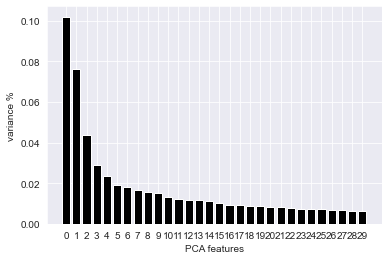

In [11]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

### How many components will you use to fit a supervised learning model?

We can see in the barplot that the additional variation explained by each principal component diminishes after the first 5 to 9 principal components. We could go with any number of components between 5 to 9, but given that cumulative variation explained drops only by about 3 percentage points from 34% to 31% between 9 and 7 components, and from 31% to 27% between 7 and 5 components, it makes sense to go with either 5 or 6 principal components to fit a supervised learning method.

### 2D Scatterplot of the first two components

In [12]:
pc_df = pd.DataFrame(data = principalComponents_nhanes)
pc_df

plot_df = pd.concat([pc_df, hsd010], axis = 1)

#Recode to make hsd010 binary
plot_df['HSD010_binary'] = hsd010_binary = plot_df['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])
plot_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,HSD010,HSD010_binary
0,9.527808,-0.816221,-1.868081,-2.108121,-3.930095,-0.179049,-3.841871,-2.946065,1.531180,0.683736,...,0.363677,0.440481,-1.314841,-0.579369,-0.133072,-0.282668,-0.614597,-0.076011,1,good
1,-5.838345,-3.692587,3.807545,-1.031807,0.401016,1.596274,2.724678,-0.739950,0.300928,-2.442355,...,1.341194,4.910683,-1.217748,-0.734808,-1.122702,1.223732,0.534791,0.311704,1,good
2,-0.719446,-2.573186,0.907694,-4.757237,-1.797630,0.867443,-1.016294,0.636440,0.523196,0.451533,...,-0.151340,-0.723665,0.084866,0.865148,0.965616,-0.135486,-0.649537,-0.023690,2,good
3,3.533635,-2.576979,-3.249201,-0.406284,4.000173,1.440053,-1.183271,0.316930,-4.147057,-1.248987,...,-1.453944,1.530746,-0.905864,-0.918649,0.536972,-0.615554,-0.487576,1.651599,2,good
4,-6.872078,-4.194185,0.886928,-0.851332,-0.515086,0.063506,0.862113,1.004625,0.503325,-0.035134,...,0.393810,-2.391472,0.524000,-0.247223,0.312787,3.112479,-0.011228,0.166136,3,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,2.643315,-1.689343,-0.702960,-0.537858,-1.023620,-0.674032,0.467053,-0.291370,0.973693,-1.234227,...,0.303803,2.716569,-0.515785,-1.060424,-0.673701,0.370323,1.534938,0.392922,3,good
2060,1.037906,-0.118043,5.556702,1.628885,0.970775,1.144351,1.950645,0.947229,-1.296202,-2.008155,...,0.093855,-0.127592,-0.704475,1.164629,0.365697,-0.530857,1.065613,-0.331878,2,good
2061,1.130267,-0.970436,3.415287,1.208747,-3.629892,1.115180,1.358842,1.823680,-2.344611,0.237562,...,1.227751,2.072603,1.904550,0.386116,2.655593,1.463904,-0.213815,0.569550,4,poor
2062,7.145104,-0.376761,1.752941,-0.935621,-4.670895,3.844624,-1.354698,2.566792,-0.278719,0.620409,...,-0.821693,0.620558,-0.465042,0.791347,1.072442,-0.531267,-0.933362,0.308191,1,good


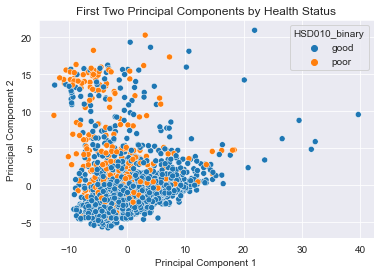

In [13]:
ax = sns.scatterplot(x = plot_df[0], y = plot_df[1], hue = 'HSD010_binary', data = plot_df)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 2")
ax.set_title("First Two Principal Components by Health Status")
plt.show()

* Provide 1-2 sentences analyzing the plot

## Clustering

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### K-Means Clustering

The k-means algorithm divides a set of samples into k clusters, arbitrarily in an initial division and then adjusted based on the nearest cluster centroid (the mean of the samples in that cluster). The process of assigning and re-calculating the centroid is repeated until the old and new centroids no longer change significantly; i.e., until the optimal centroids are identified with the aim to minimize the within-cluster sum of squares. 

### Cluster nhanes

To determine the number of clusters, we use both the elbow method and silhouette coefficient.

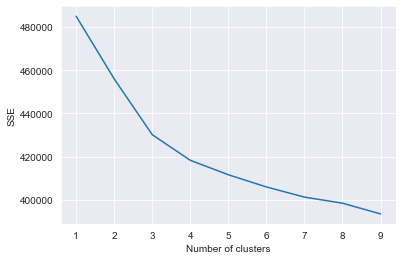

In [14]:
np.random.seed(10)

# Elbow Method
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=300).fit(nhanes_scaled_X)
    nhanes_scaled_X["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

The elbow method shows an optimal number of clusters around 3 or 4. 

To see which would be a better choice, we also calculate the silhoette score, which gives a measures of how close or far a cluster is from neighboring clusters. The score ranges from -1 to 1, where a value closer to 1 indicates that the cluster is further away from neighboring clusters and a score near 0 indicates that the clusters are very close to neighboring clusters. A negative score may be indicative of incorrect cluster assignment.  

In [15]:
# Silhouette Coefficient
from sklearn.metrics import silhouette_score

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(nhanes_scaled_X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(nhanes_scaled_X, label, metric='euclidean')
    print("For n_clusters={}, the silhouette score is {}".format(n_cluster, sil_coeff))


For n_clusters=2, the silhouette score is 0.08499873957430466
For n_clusters=3, the silhouette score is 0.09159984821921215
For n_clusters=4, the silhouette score is 0.033694008130643466
For n_clusters=5, the silhouette score is 0.035978126511861094
For n_clusters=6, the silhouette score is 0.034362936962607345
For n_clusters=7, the silhouette score is 0.027785695567170317
For n_clusters=8, the silhouette score is 0.025575062506601468
For n_clusters=9, the silhouette score is 0.027027895172073747
For n_clusters=10, the silhouette score is 0.023106660221695437


The silhouette score is highest for 3 clusters and substantially higher than 4 clusters, so we choose 3 clusters.

In [16]:
# Choose 3 clusters
kmeans = KMeans(n_clusters=3,
               max_iter=300 #default
               ).fit(nhanes_scaled_X)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [17]:
nhanes_scaled_X['labels'] = kmeans.labels_

In [18]:
nhanes_scaled_X['labels'].value_counts()

1    1278
2     569
0     217
Name: labels, dtype: int64

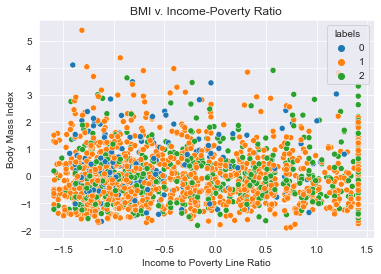

In [19]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue="labels", palette = "tab10", data = nhanes_scaled_X)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

The scatterplot above doesn't show a very strong relationship between the cluster assignment and the income to poverty line ratio or BMI. Cluster 0 is a bit more clustered around negative income to poverty line ratio values compared to clusters 1 and 2, which are pretty evenly spread out. But there is no clear separation between the three groups when looking at these two variables. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

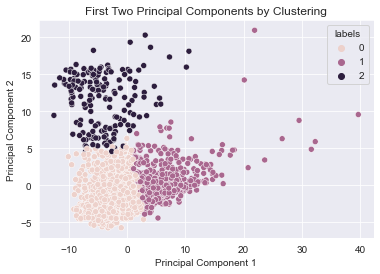

In [20]:
## Convert HSD010 to integer
plot_df['HSD010_binary'] = hsd010_binary = plot_df['HSD010'].replace(
    ['good', 'good', 'good', 'poor', 'poor'], [1, 1, 1, 0, 0], )
plot_df

kmeans = KMeans(n_clusters=3,
               max_iter=300 #default
               ).fit(plot_df)

plot_df['labels'] = kmeans.labels_
plot_df['labels'].value_counts()

ax = sns.scatterplot(x = plot_df[0], y = plot_df[1], hue = 'labels', data = plot_df)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 2")
ax.set_title("First Two Principal Components by Clustering")
plt.show()

The three clusters are much more distinct in this scatterplot of the first two principal components. Cluster 0 has lower values for both PC1 and PC2. Cluster 1 has low values of PC2 (between around 2 and -10) but higher values of PC1 (between around 3 and 18), with some extreme outliers. Cluster 2 has higher values of PC2 (between 5 and 20) and lower values of PC1 (mostly between 0 and -10). 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [21]:
# Looking back at the original dataset
nhanes_scaled

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,HSD010_binary
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,excellent,good
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,excellent,good
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,very good,good
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,very good,good
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83694,0.0,0.261930,0.0,0.324834,-0.481375,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,0.480384,1.087115,-0.683338,0.612440,good,good
83696,0.0,0.495138,0.0,0.324834,1.093063,0.634362,-0.194202,-0.057306,0.128246,-0.189513,...,0.246091,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,very good,good
83704,0.0,0.728346,0.0,-3.078499,0.305844,-0.268620,-0.194202,-0.057306,0.128246,0.080373,...,2.031441,2.065262,1.125008,0.0,0.480384,-0.919866,-0.683338,-1.632812,fair,poor


In [22]:
# Recode hsd010_binary with the original integer labels
nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010_binary'].replace(
    ['good', 'poor'], [1, 0])

nhanes_scaled['HSD010_binary']

SEQN
73568    1
73576    1
73579    1
73581    1
73584    1
        ..
83694    1
83696    1
83704    0
83716    1
83721    1
Name: HSD010_binary, Length: 2064, dtype: int64

In [23]:
# Set up the data for the NN model
y = nhanes_scaled['HSD010_binary'] # either hsd010 or hsd010_binary
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [24]:
X_test.shape

(516, 241)

In [25]:
y_test.shape

(516,)

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes=2)
y_test = np_utils.to_categorical(y_test, num_classes=2)

num_classes = y_test.shape[1]
num_classes

ModuleNotFoundError: No module named 'keras'

In [ ]:
model = Sequential()

model.add(
    Dense(num_classes, input_dim= X_test.shape[1], kernel_initializer= 'normal', activation= 'relu')
)

model.add(
    Dense(num_classes, kernel_initializer= 'normal', activation= 'sigmoid')
)

## Add any additional layers you wish here

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=2, verbose=2)

### Neural Network on Principal Components

In [ ]:
plot_df

In [ ]:
# Set up the data for the PCA NN model
y = nhanes_scaled['HSD010_binary']
X = plot_df.drop(['HSD010', 'HSD010_binary','labels'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes=2)
y_test = np_utils.to_categorical(y_test, num_classes=2)

num_classes = y_test.shape[1]
num_classes

# NN model with PCA features
model = Sequential()

model.add(
    Dense(num_classes, input_dim= X_test.shape[1], kernel_initializer= 'normal', activation= 'relu')
)

model.add(
    Dense(num_classes, kernel_initializer= 'normal', activation= 'sigmoid')
)

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=2, verbose=2)


### Neural Network on Principal Components + Cluster Membership

In [ ]:
# Set up the data for the PCA+clustering NN model
y = nhanes_scaled['HSD010_binary']
X = plot_df.drop(['HSD010', 'HSD010_binary'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes=2)
y_test = np_utils.to_categorical(y_test, num_classes=2)

num_classes = y_test.shape[1]
num_classes

# NN model with PCA+cluster features
model = Sequential()

model.add(
    Dense(num_classes, input_dim= X_test.shape[1], kernel_initializer= 'normal', activation= 'relu')
)

model.add(
    Dense(num_classes, kernel_initializer= 'normal', activation= 'sigmoid')
)

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=2, verbose=2)




* Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

## Discussion Questions

#### 1. In your own words, what is the difference between PCA and clustering?

While PCA and clustering are both unsupervised machine learning methods, they are relatively different in their ultimate goals. PCA is a dimension reduction technique. The goal is to maximize as much of the variation in the data as possible by using far fewer features. It creates new features as linear combinations of original features, which serve to project the data on a two dimensional plane. Clustering, on the other hand, is a grouping technique. Its goal is to separate the data into distinct clusters of similar data points based on selected features, instead of creating new features. Data points within clusters are much more similar relative to data points in neighboring clusters. 

#### 2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

#### 3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques help to better understand and describe big data and can uncover interesting patterns. This may help guide research questions or select features. Clustering, for example, can uncover interesting relationships between variables that can then be analysed more explicitly in a supervised learning task. Unsupervised techniques can also be used in supervised learning. PCA, for example, can explain a large part of variation in the data using significantly fewer features, reducing variance of weights in the supervised step and is often used to capture a broader concept, like wealth or empowerment, which are then often used within regression models or other supervised learning tasks. 
